In [143]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import pandas as pd
import keras
from PIL import Image, ImageOps, ImageStat
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential # basic class for specifying and training a neural network
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
import pickle as pkl
import h5py

/Users/xc5523/Documents/Sources/datascience/engie_ds/rooftop/venv-rooftop/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data exploration

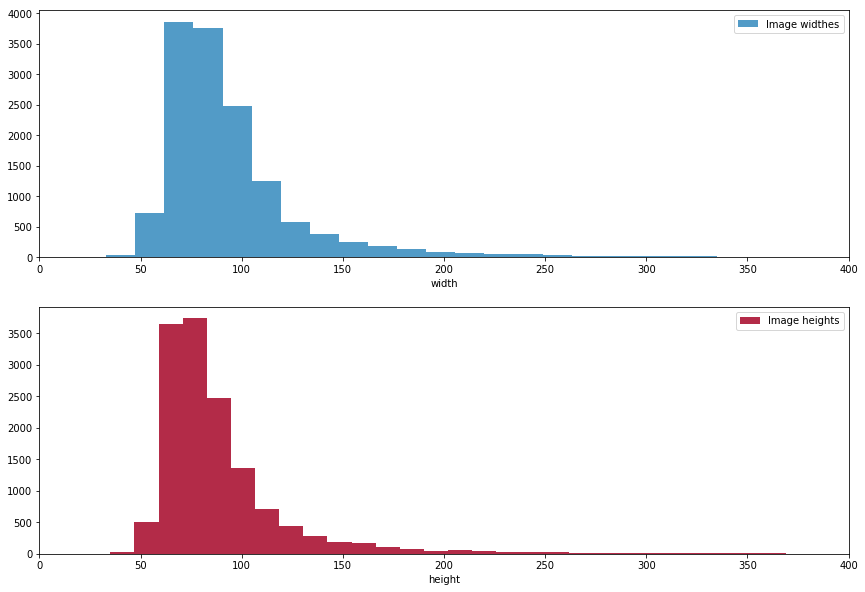

In [60]:
x, y = [], []
for k in glob.glob('images/*.jpg'):
    size = Image.open(k).size
    x.append(size[0])
    y.append(size[1])
figsize(14.5, 10)
ax = plt.subplot(211)
plt.hist(x, histtype='stepfilled', bins=100, alpha=.85, label='Image widthes', color='#348ABD', normed=False)
plt.legend(loc="upper right")
plt.xlim([0, 400])
plt.xlabel('width')

ax = plt.subplot(212)
plt.hist(y, histtype='stepfilled', bins=100, alpha=.85, label='Image heights', color='#A60628', normed=False)
plt.legend(loc="upper right")
plt.xlim([0, 400])
_ = plt.xlabel('height')

# Prepare dataset

In [82]:
target_size = 100
def get_image_values(impath):
    im = Image.open(impath).convert('L')
    width, height = im.size
    left = max(0, (width - target_size)/2)
    top = max(0, (height - target_size)/2)
    right = min(width, (width + target_size)/2)
    bottom = min(height, (height + target_size)/2)
    new_im = Image.new('L', (target_size, target_size), (int(ImageStat.Stat(im).mean[0])))
    new_im.paste(im, (int((target_size - width) / 2), int((target_size - height) / 2)))
    return np.array(new_im).reshape(target_size, target_size, 1)

In [83]:
# Read labels
labels = pd.read_csv('train.csv', index_col='id')
n_images = len(labels)
y = []
x = []
for row_idx in tqdm(range(n_images)):
    lrow = labels.iloc[row_idx]
    y.append(lrow.values[0])
    x0 = get_image_values("images/{}.jpg".format(lrow.name))
    x.append(x0)
y = np.array(y)
x = np.array(x)
print(y.shape)
print(x.shape)

100%|██████████| 9980/9980 [00:07<00:00, 1375.53it/s]

(9980,)
(9980, 100, 100, 1)


In [84]:
# Split the data up in train and test sets
n_classes = np.unique(y).shape[0]
x_train, x_test, y_train, y_test = train_test_split(x/255, y, test_size=0.33, random_state=42)
y_train = np_utils.to_categorical(y_train - 1, n_classes)
y_test = np_utils.to_categorical(y_test - 1, n_classes)

# Model

In [132]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 25 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 8 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 16 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size_1 = 512 # the FC layer will have 512 neurons
hidden_size_2 = 64 # the FC layer will have 512 neurons
lrate = 0.01
decay = 1e-6

In [133]:
# Create the model
model = Sequential()
model.add(Convolution2D(conv_depth_1, (kernel_size, kernel_size), input_shape=(target_size, target_size, 1), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#model.add(Dropout(drop_prob_1))
model.add(Convolution2D(conv_depth_2, (kernel_size, kernel_size), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(hidden_size_1, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(drop_prob_2))
model.add(Dense(hidden_size_2, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(drop_prob_2))
model.add(Dense(n_classes, activation='softmax'))
# Compile model
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
__________

In [134]:
model.fit(x_train, y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(x_test, y_test, verbose=1)  # Evaluate the trained model on the test set!

Train on 6017 samples, validate on 669 samples
Epoch 1/25
6017/6017 [==============================] - 29s 5ms/step - loss: 1.2295 - acc: 0.4574 - val_loss: 1.0456 - val_acc: 0.5561
Epoch 2/25
6017/6017 [==============================] - 27s 4ms/step - loss: 1.0828 - acc: 0.5388 - val_loss: 1.0616 - val_acc: 0.5441
Epoch 3/25
6017/6017 [==============================] - 27s 5ms/step - loss: 1.0555 - acc: 0.5551 - val_loss: 0.9667 - val_acc: 0.5904
Epoch 4/25
6017/6017 [==============================] - 28s 5ms/step - loss: 1.0241 - acc: 0.5641 - val_loss: 0.9695 - val_acc: 0.5964
Epoch 5/25
6017/6017 [==============================] - 27s 5ms/step - loss: 0.9904 - acc: 0.5745 - val_loss: 0.9420 - val_acc: 0.5994
Epoch 6/25
6017/6017 [==============================] - 27s 5ms/step - loss: 0.9724 - acc: 0.5817 - val_loss: 0.9492 - val_acc: 0.6009
Epoch 7/25
6017/6017 [==============================] - 28s 5ms/step - loss: 0.9570 - acc: 0.5953 - val_loss: 0.9317 - val_acc: 0.5994
Epoch 8/

[1.166917747704275, 0.6311475411645557]

In [144]:
model.save('model0.pkl')

ImportError: `save_model` requires h5py.

In [147]:
for k in range(14104):
    if k not in labels.index:
        get_image_values('images/*.jpg')
        print('{} in labels'.format(k))
    else:
        print('{} not in labels'.format(k))
    if k > 10:
        break


0 not in labels
1 not in labels
2 not in labels
3 not in labels
4 not in labels
5 not in labels
6 not in labels
7 not in labels
8 not in labels
9 not in labels
10 not in labels
11 not in labels


In [154]:
109983 in labels.index

False